In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [5]:
output_path = './output/latency'

/tmp/ipykernel_3496715/1542640333.py:73: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3496715/1542640333.py:73: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3496715/1542640333.py:73: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


图片已保存到: output/latency/end_to_end_latency.png


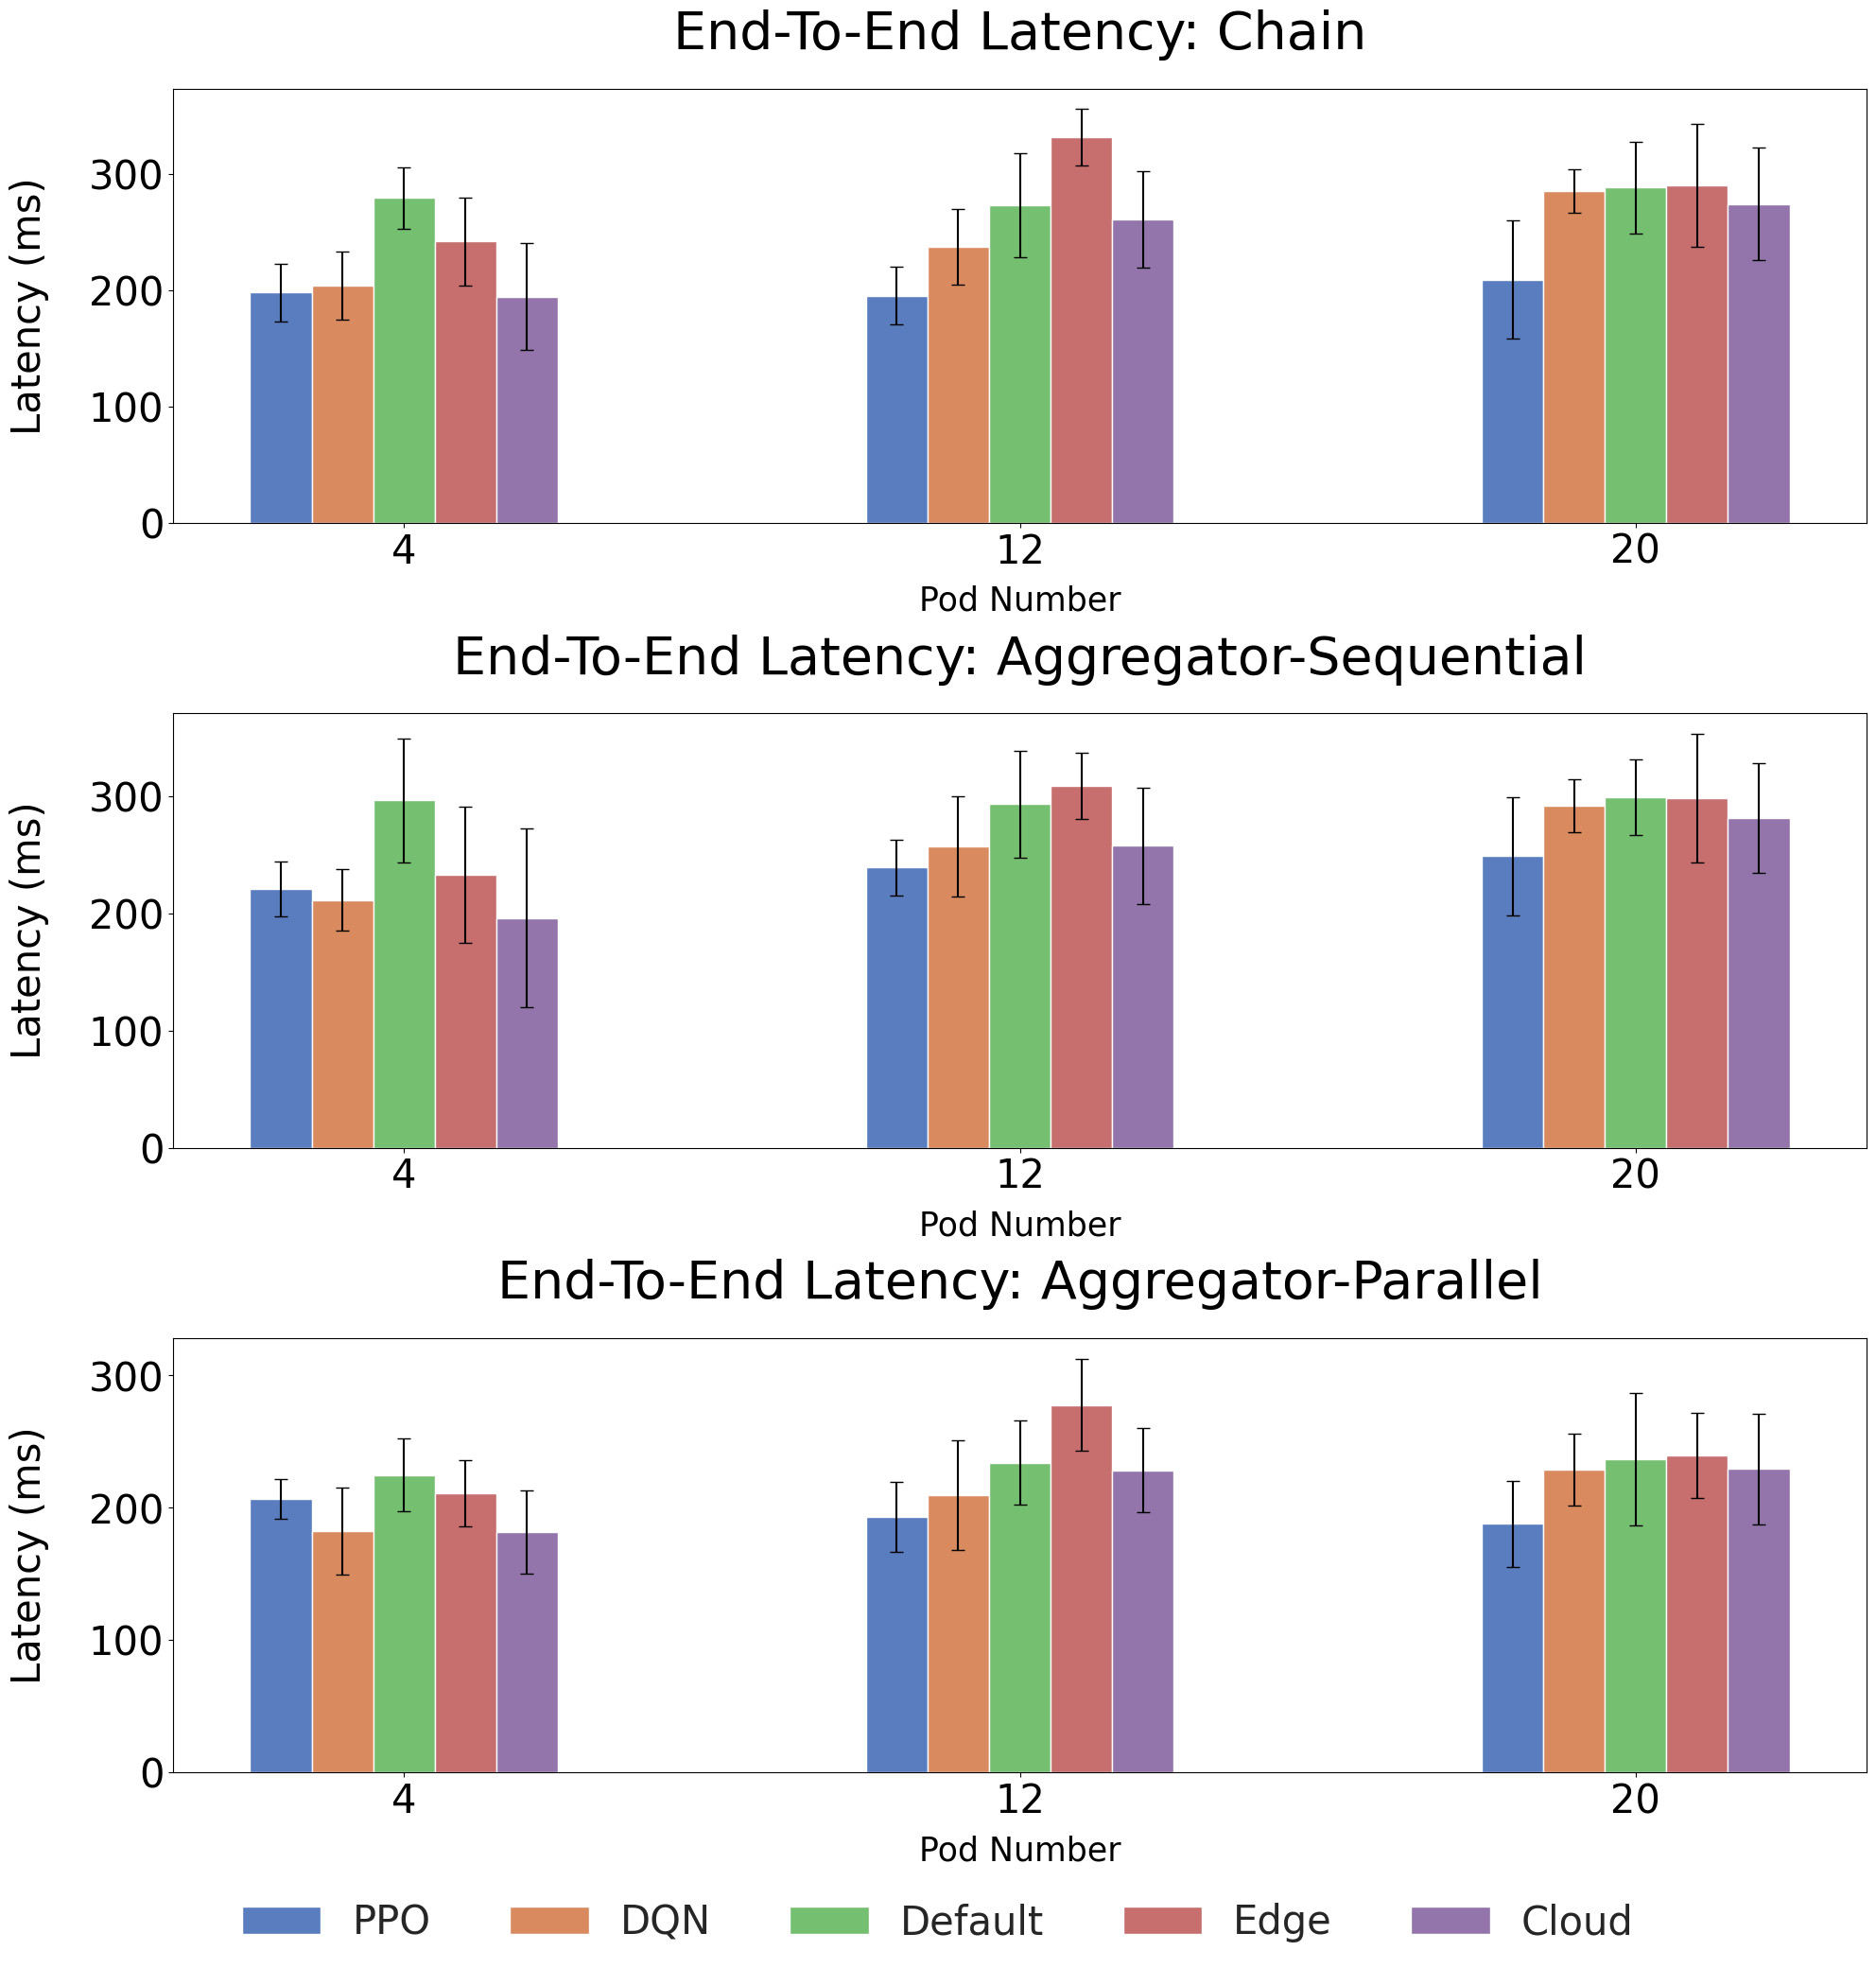

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define the path variables
rl_path = './results/complete/rl'
be_path = './results/complete/be'

# Function to load and process RL data
def load_rl_data(pattern, strategy, replica):
    filename = f"{pattern}_{strategy}_replica{replica}.csv"
    file_path = os.path.join(rl_path, filename)
    df = pd.read_csv(file_path)
    mean = df['end_total_latency'].mean()
    std = df['end_total_latency'].std()
    return mean, std

# Function to load and process BE data
def load_be_data(pattern, strategy, replica):
    filename = f"{pattern}_{strategy}_replica{replica}.csv"
    file_path = os.path.join(be_path, filename)
    df = pd.read_csv(file_path)
    mean = df['total_latency'].mean()
    std = df['total_latency'].std()
    return mean, std

# Function to compare and plot end-to-end latency
def compare_and_plot_end_to_end_latency(pattern, replicas, ax):
    # Define strategies
    rl_strategies = ['ppo', 'dqn']
    be_strategies = ['all', 'edge', 'cloud']
    
    # Create a list to store data for plotting
    data = []
    
    # Load data for each replica
    for replica in replicas:
        # Load RL data
        for rl_strategy in rl_strategies:
            rl_mean, rl_std = load_rl_data(pattern, rl_strategy, replica)
            data.append({
                'latency': rl_mean, 
                'std': rl_std,
                'strategy': rl_strategy,
                'replica': replica * 4
            })
        
        # Load BE data
        for be_strategy in be_strategies:
            be_mean, be_std = load_be_data(pattern, be_strategy, replica)
            data.append({
                'latency': be_mean, 
                'std': be_std,
                'strategy': be_strategy,
                'replica': replica * 4
            })
    
    # Convert the data to a DataFrame
    plot_df = pd.DataFrame(data)
    
    # Rename 'all' to 'Kubernetes Default' for display
    plot_df['strategy'] = plot_df['strategy'].replace('all', 'Default')
    plot_df['strategy'] = plot_df['strategy'].replace('ppo', 'PPO')
    plot_df['strategy'] = plot_df['strategy'].replace('dqn', 'DQN')
    plot_df['strategy'] = plot_df['strategy'].replace('edge', 'Edge')
    plot_df['strategy'] = plot_df['strategy'].replace('cloud', 'Cloud')

    # Set the plot style
    sns.set(style="whitegrid")
    
    # Create the bar plot with error bars
    sns.barplot(
        x='replica', 
        y='latency', 
        hue='strategy', 
        data=plot_df, 
        ci=None, 
        ax=ax,
        palette="muted",
        width=0.5
    )
    
    # Add error bars
    for patch, std in zip(ax.patches, plot_df['std']):
        # Calculate the center of each bar
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        # Add error bar
        ax.errorbar(x, y, yerr=std, fmt='none', c='black', capsize=5, linewidth=1.5)
    pattern_map = {
        "chain": "Chain",
        "aggregator_sequential": "Aggregator-Sequential",
        "aggregator_parallel": "Aggregator-Parallel"
    } 
    # Set titles and labels
    ax.set_title(f'End-To-End Latency: {pattern_map[pattern]}', fontsize=40, pad=30)
    ax.set_xlabel('Pod Number', fontsize=25, labelpad=10)
    ax.set_ylabel('Latency (ms)', fontsize=30, labelpad=30)
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax.get_legend().remove()

# Main function to generate three plots in a single image
def generate_three_plots(patterns, replicas, output_path=None):
    fig, axs = plt.subplots(len(patterns), 1, figsize=(20, 20))  # 减小每个子图的高度
    
    # Plot each pattern in separate subplots
    for i, pattern in enumerate(patterns):
        compare_and_plot_end_to_end_latency(pattern, replicas, axs[i])
    
    # Set legend for the entire figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=30, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(handles), frameon=False)
    
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
        print(f"图片已保存到: {output_path}")
    else:
        plt.show()

# Generate three plots for specific patterns
generate_three_plots(['chain', 'aggregator_sequential', 'aggregator_parallel'], [1, 3, 5], "output/latency/end_to_end_latency.png")


In [5]:
import pandas as pd
import os

# Define the path variables
rl_path = './results/complete/rl'
be_path = './results/complete/be'

# Function to load and process RL data
def load_rl_data(pattern, strategy, replica):
    filename = f"{pattern}_{strategy}_replica{replica}.csv"
    file_path = os.path.join(rl_path, filename)
    df = pd.read_csv(file_path)
    mean = df['end_total_latency'].mean()
    return mean

# Function to load and process BE data
def load_be_data(pattern, strategy, replica):
    filename = f"{pattern}_{strategy}_replica{replica}.csv"
    file_path = os.path.join(be_path, filename)
    df = pd.read_csv(file_path)
    mean = df['total_latency'].mean()
    return mean

# Function to calculate average latency for each strategy across patterns
def calculate_average_latency_by_strategy(patterns, replicas):
    # Define strategies
    strategies = {
        'ppo': [],
        'dqn': [],
        'all': [],
        'edge': [],
        'cloud': []
    }
    
    # Iterate through each pattern, strategy, and replica
    for pattern in patterns:
        for replica in replicas:
            # Calculate RL strategies latencies
            for rl_strategy in ['ppo', 'dqn']:
                mean_latency = load_rl_data(pattern, rl_strategy, replica)
                strategies[rl_strategy].append(mean_latency)
                
            # Calculate BE strategies latencies
            for be_strategy in ['all', 'edge', 'cloud']:
                mean_latency = load_be_data(pattern, be_strategy, replica)
                strategies[be_strategy].append(mean_latency)
    
    # Calculate average latency for each strategy
    average_latencies = {strategy: (sum(latencies) / len(latencies) if latencies else 0)
                         for strategy, latencies in strategies.items()}
    return average_latencies

# Example usage
patterns = ['chain', 'aggregator_sequential', 'aggregator_parallel']
replicas = [1, 3, 5]
average_latencies_by_strategy = calculate_average_latency_by_strategy(patterns, replicas)
print("Average Latencies by Strategy:", average_latencies_by_strategy)

Average Latencies by Strategy: {'ppo': np.float64(211.08466760686542), 'dqn': np.float64(234.22890614522748), 'all': np.float64(269.5506593406593), 'edge': np.float64(270.3877142857143), 'cloud': np.float64(233.83895238095238)}


/tmp/ipykernel_3015135/1699681929.py:75: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


图片已保存到: ./output/latency/end_to_end_latency_chain.png


/tmp/ipykernel_3015135/1699681929.py:75: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


图片已保存到: ./output/latency/end_to_end_latency_aggregator_sequential.png


/tmp/ipykernel_3015135/1699681929.py:75: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


图片已保存到: ./output/latency/end_to_end_latency_aggregator_parallel.png


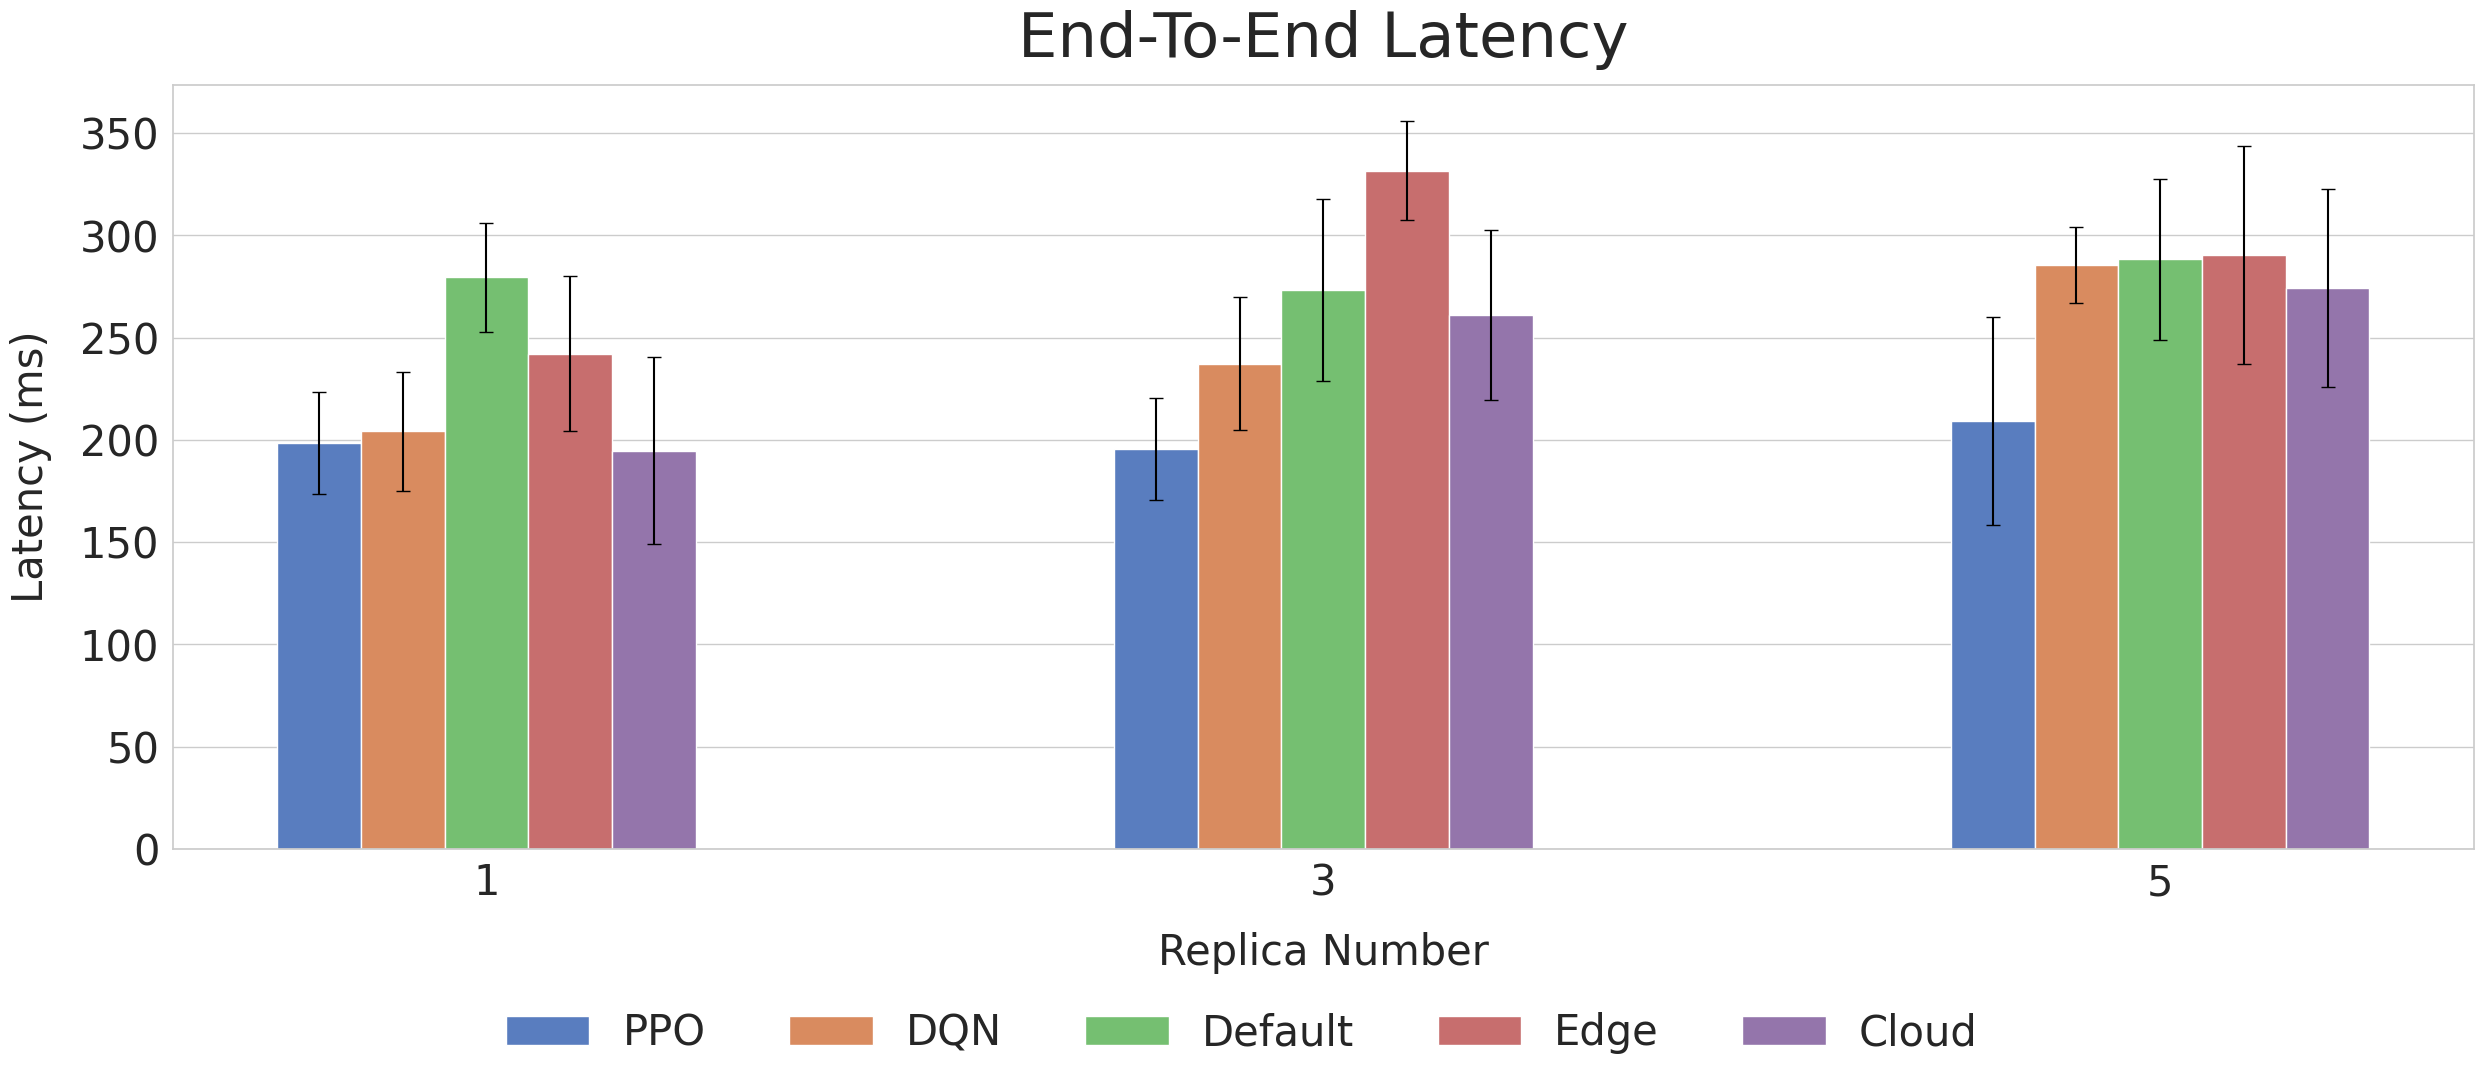

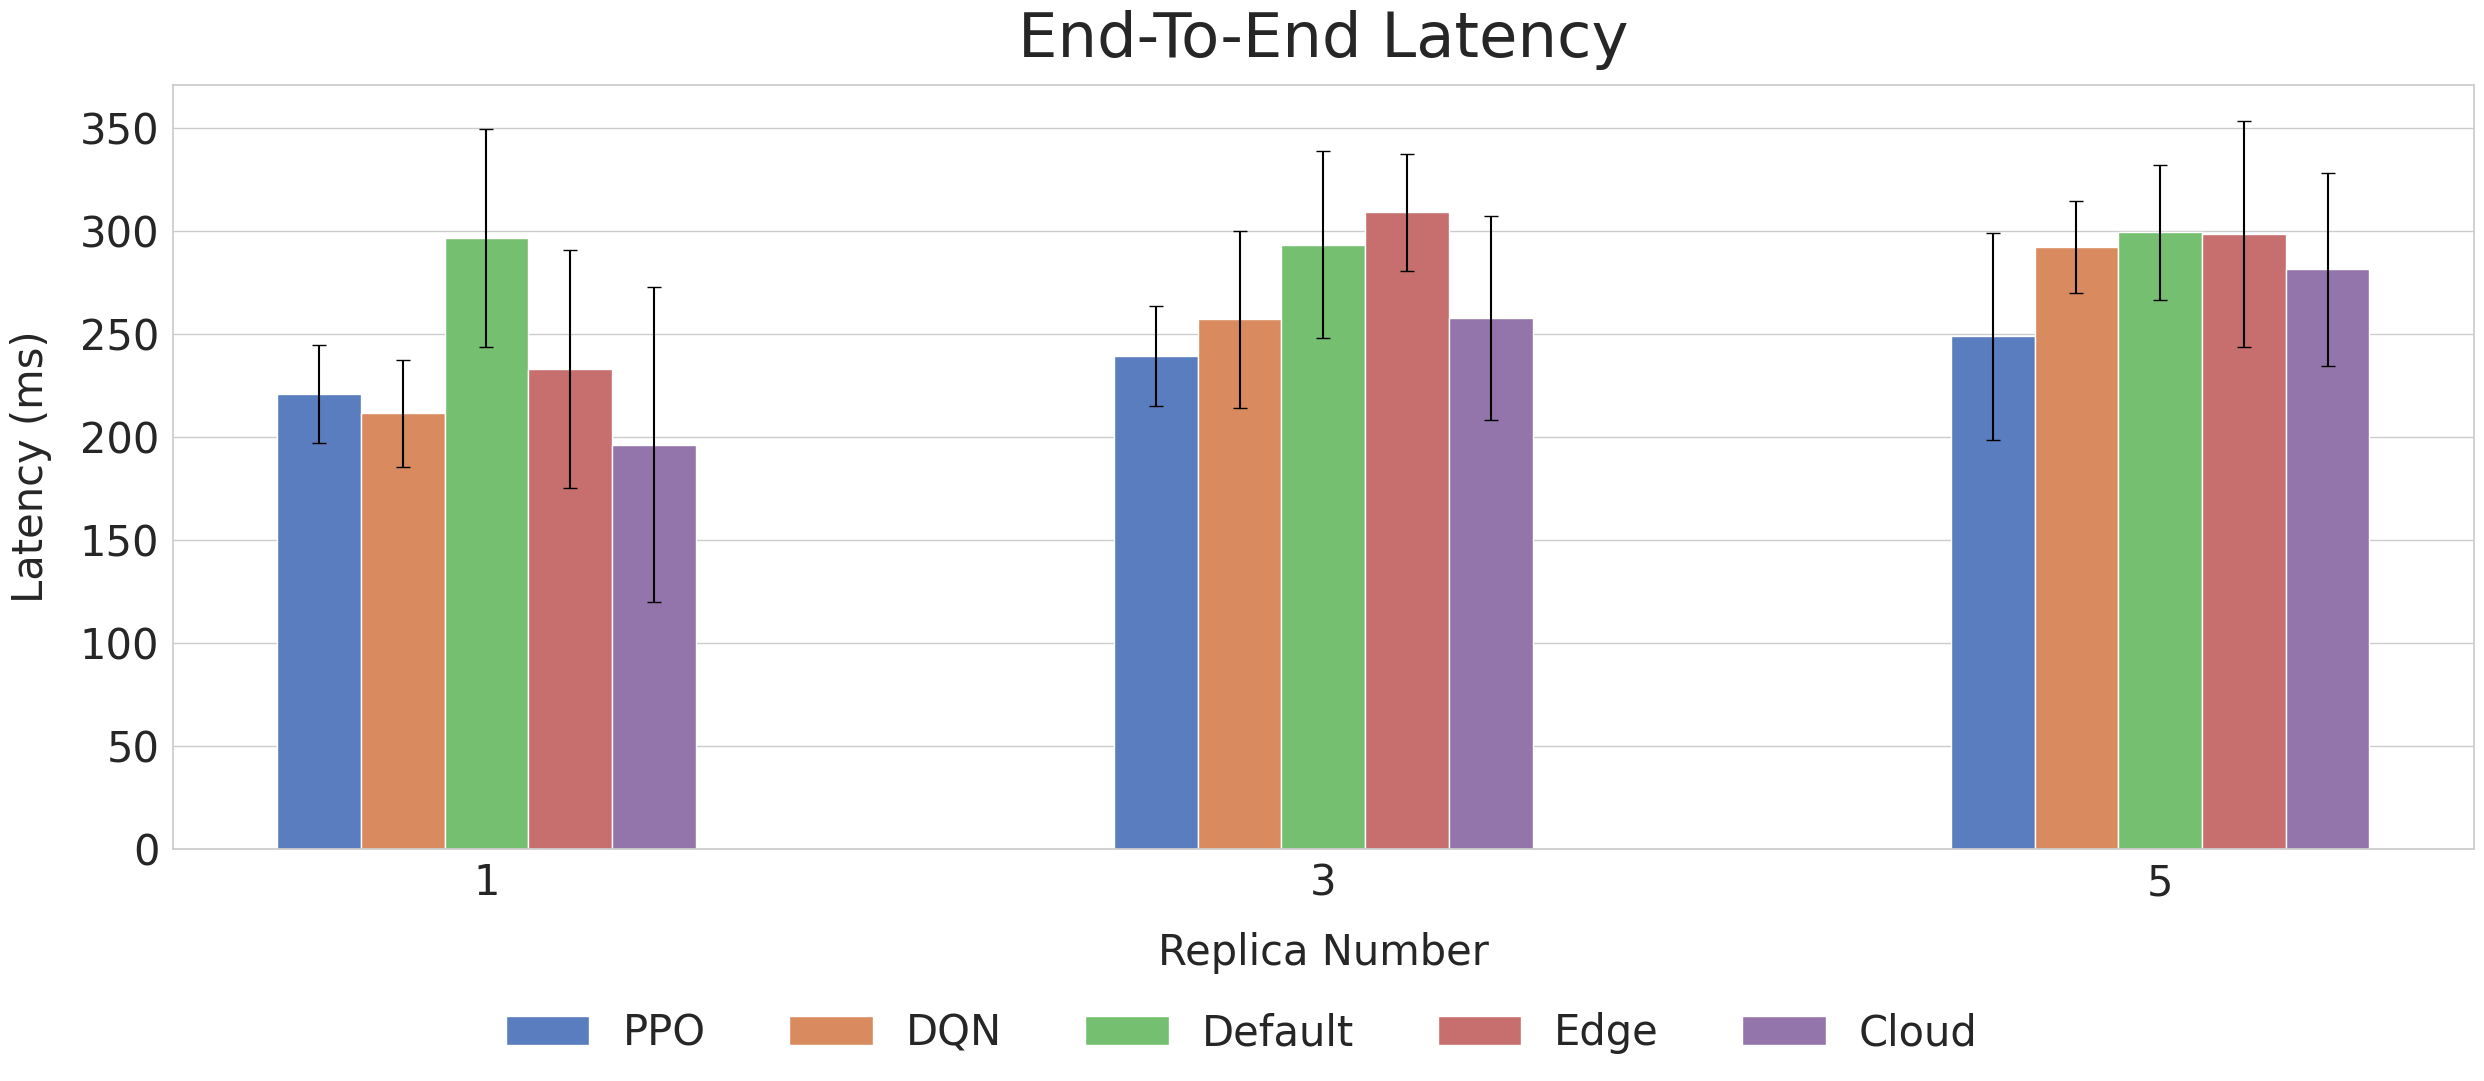

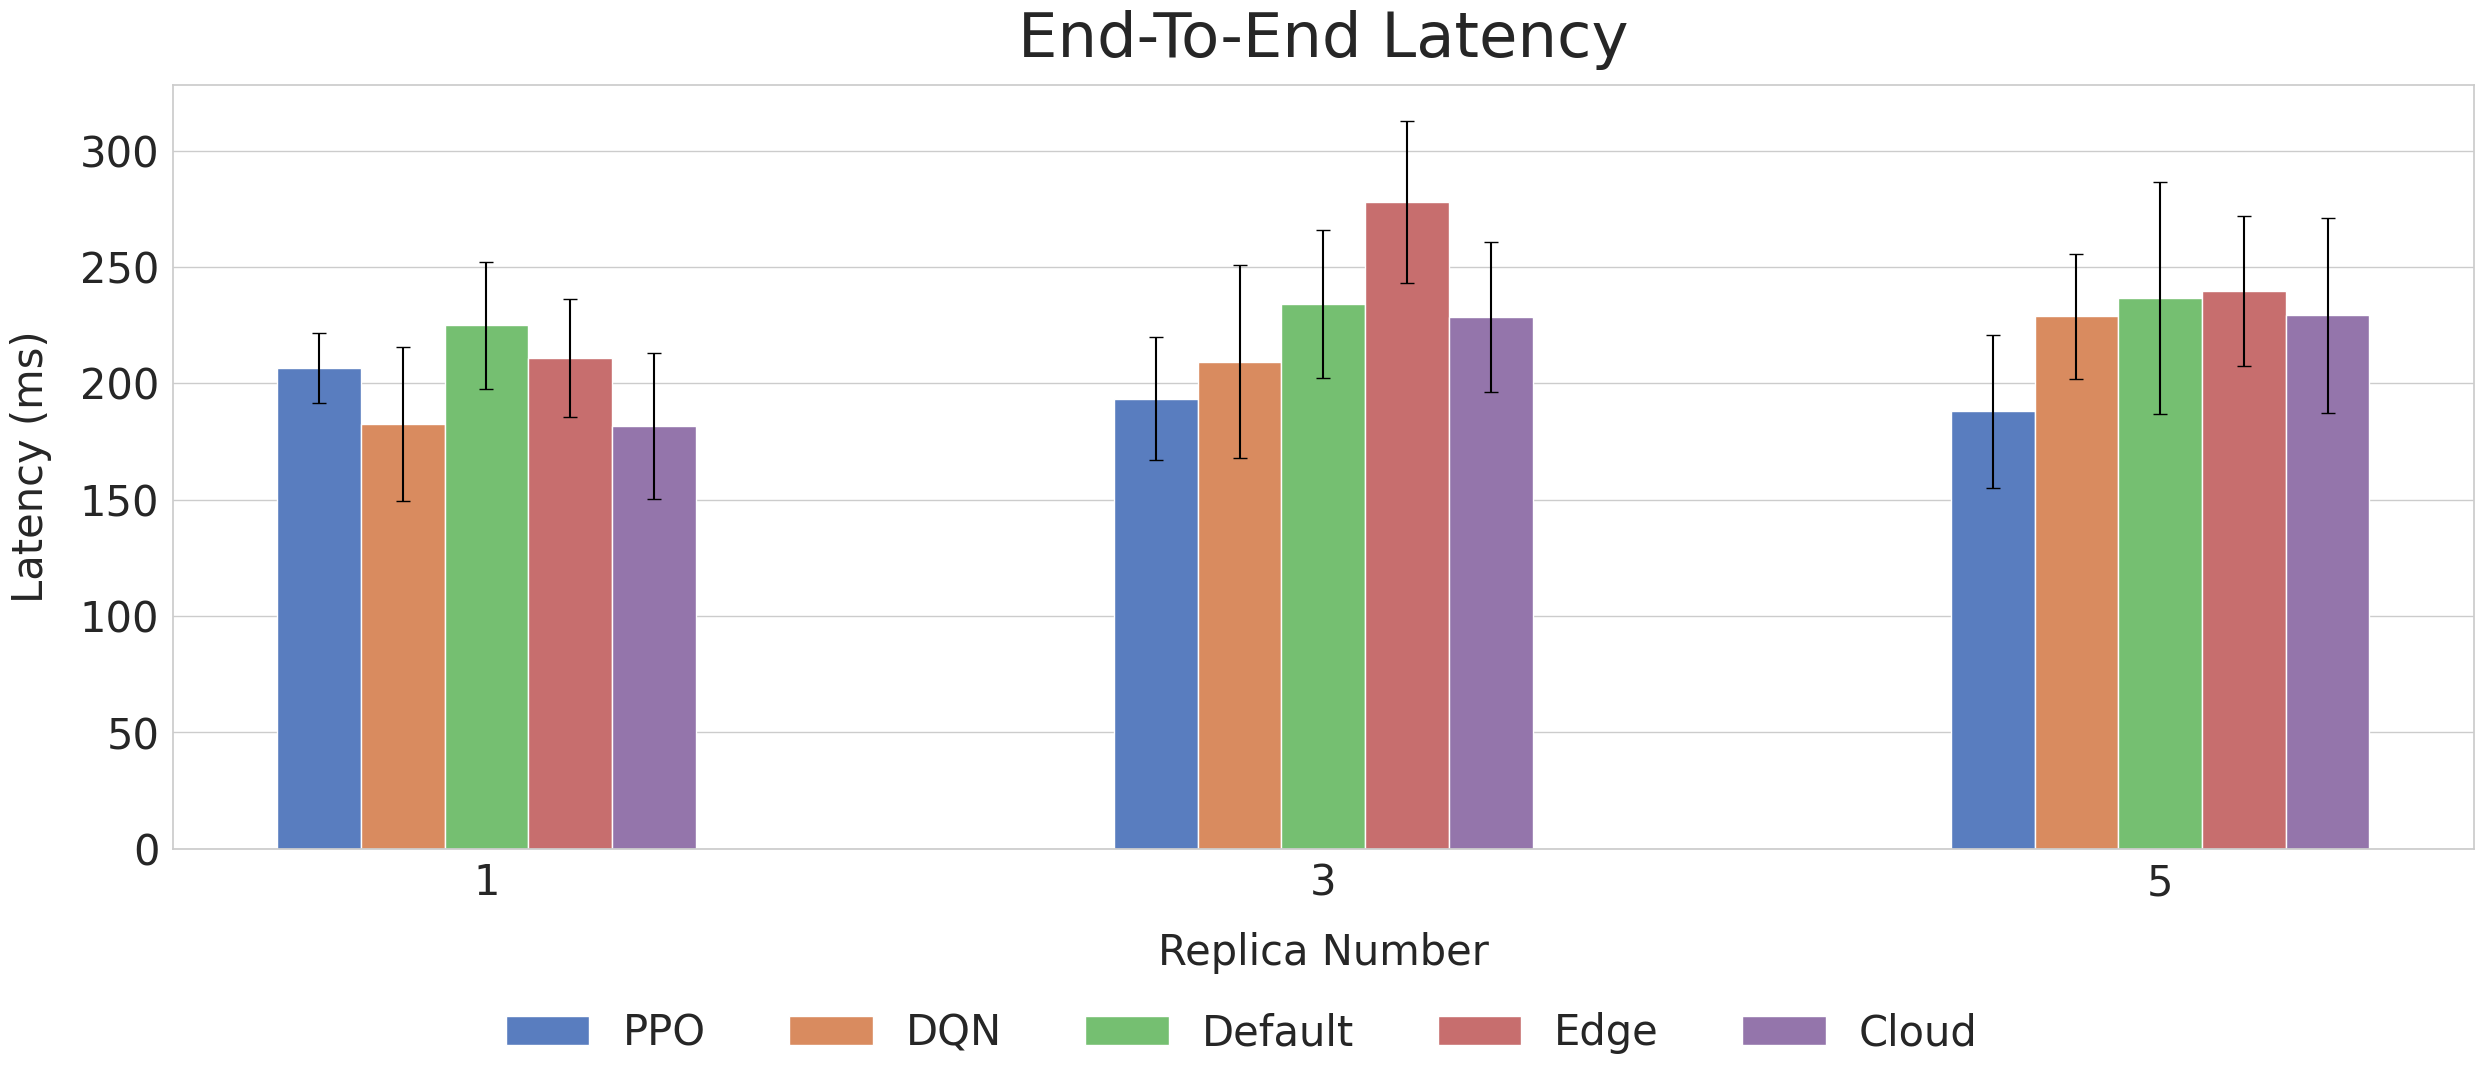

In [13]:
for pattern in ['chain', 'aggregator_sequential', 'aggregator_parallel']:
    compare_and_plot_end_to_end_latency(pattern, [1, 3, 5], f"{output_path}/end_to_end_latency_{pattern}.png")

/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


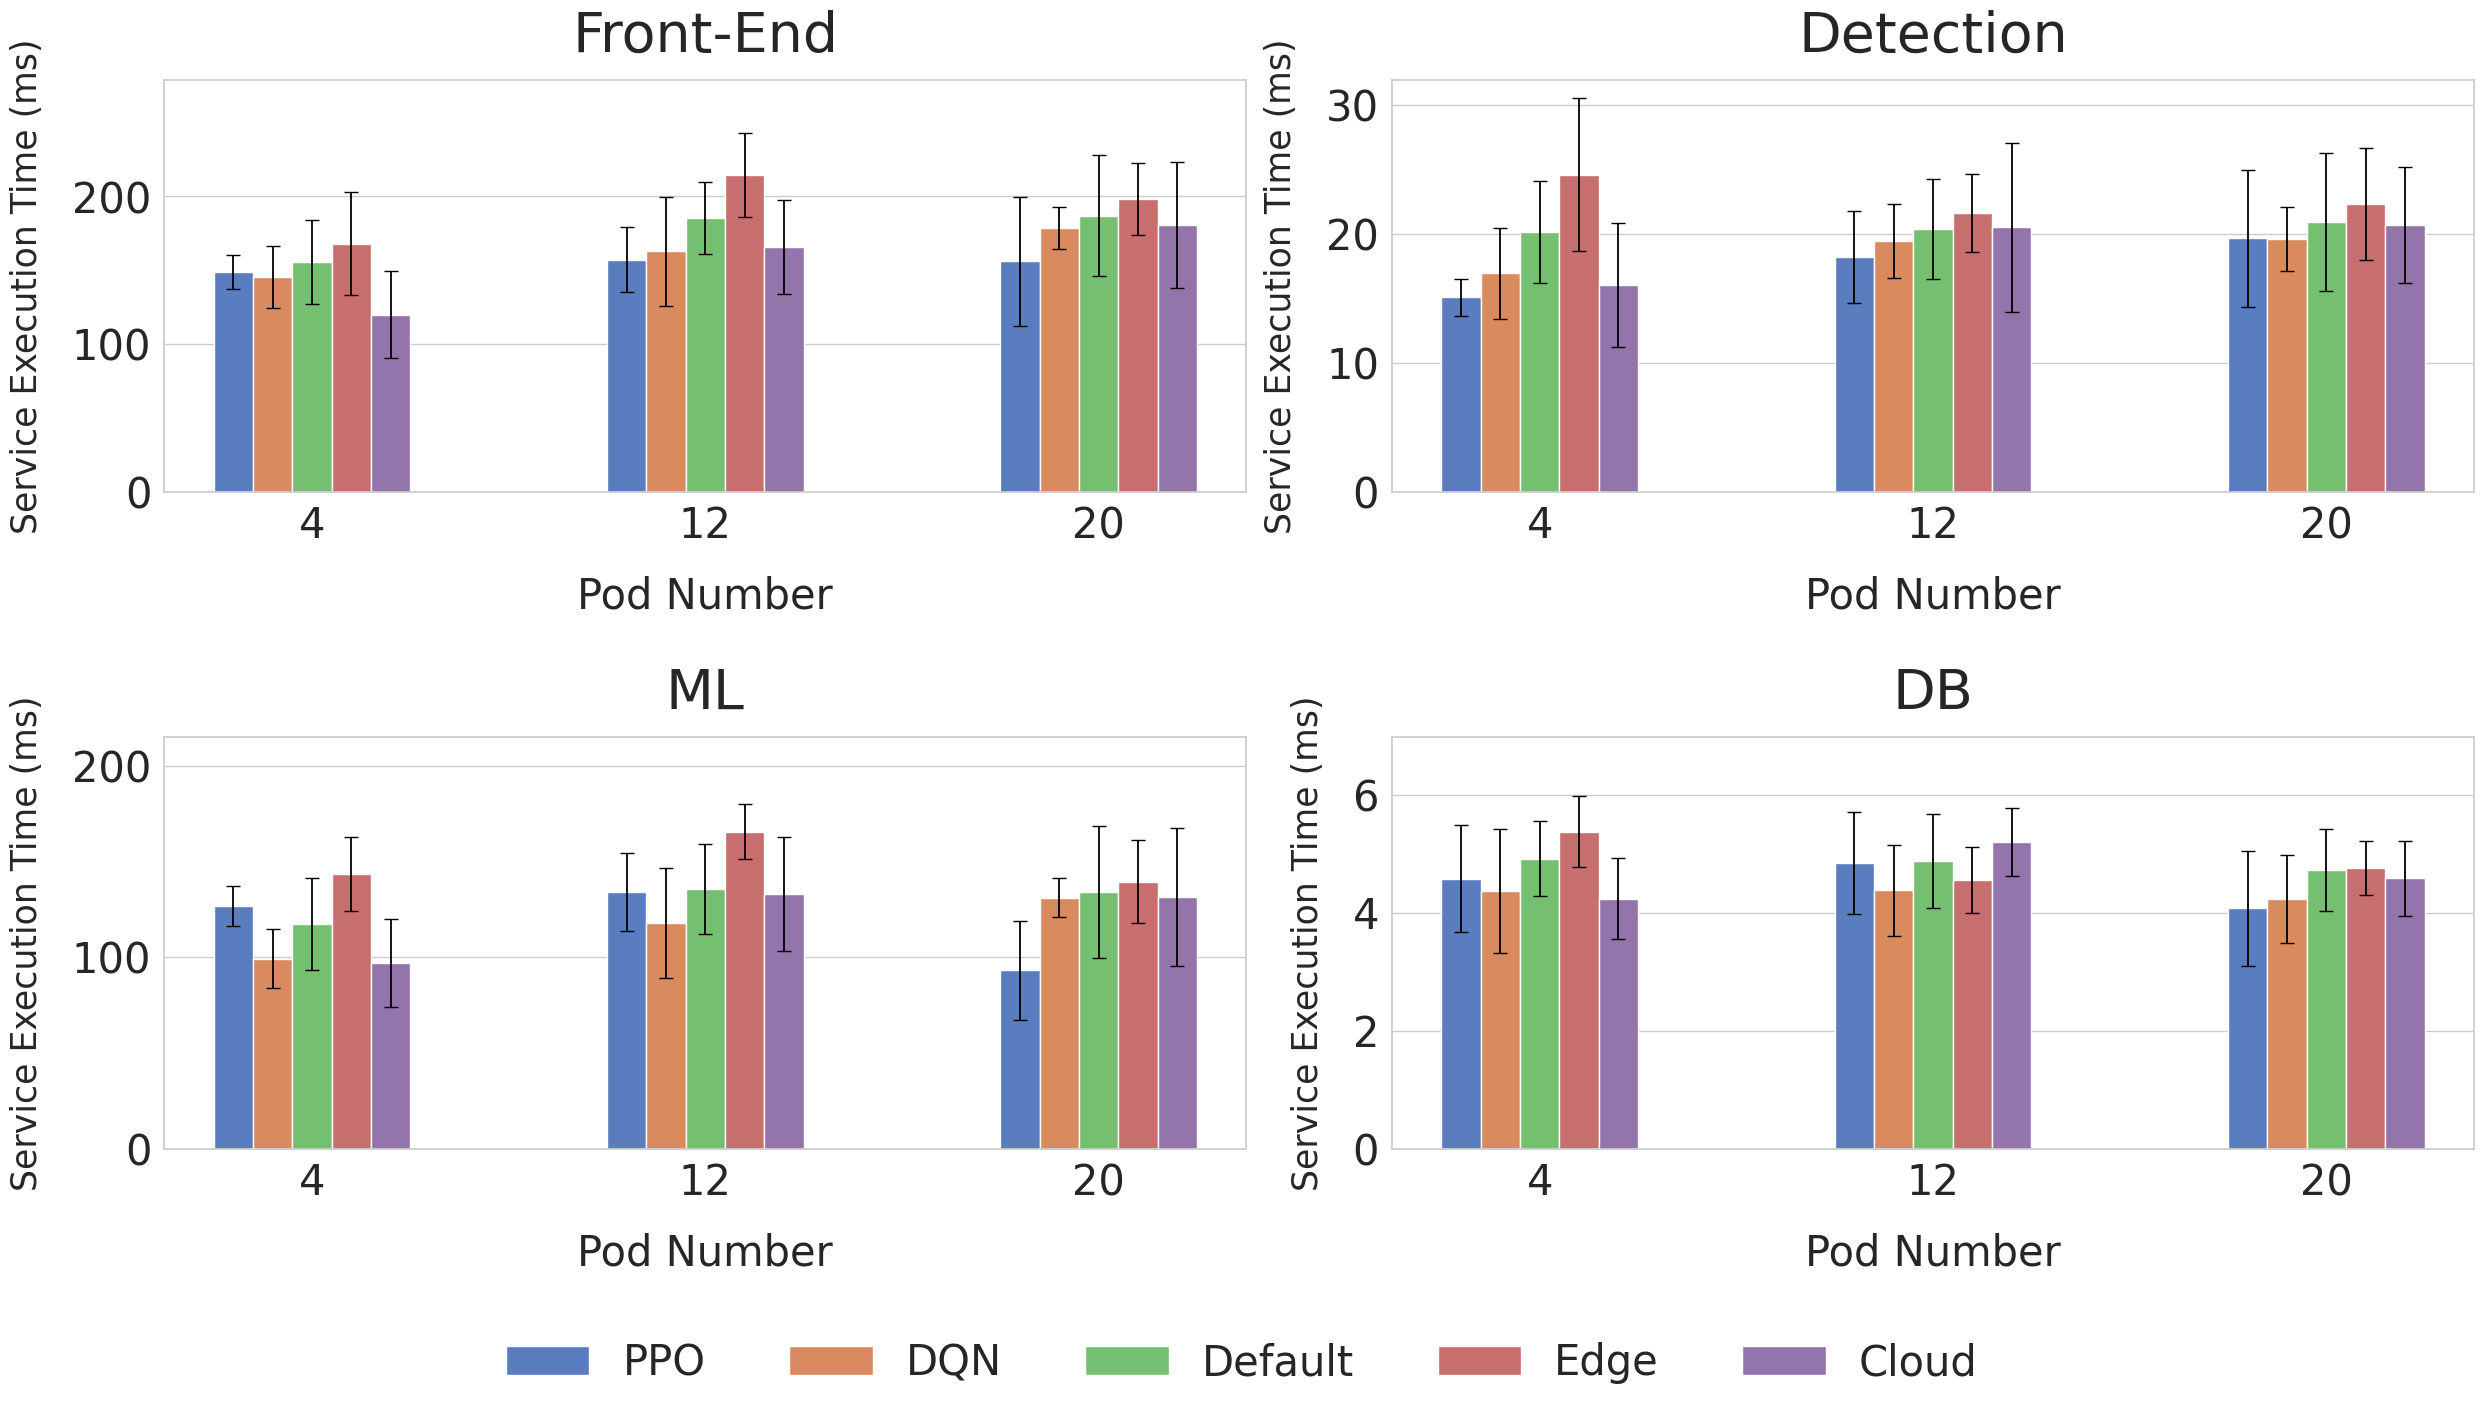

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define the path variables
rl_path = './results/complete/rl'
be_path = './results/complete/be'

# Function to load and process RL data
def load_rl_data(pattern, strategy, replica):
    filename = f"{pattern}_{strategy}_replica{replica}.csv"
    file_path = os.path.join(rl_path, filename)
    df = pd.read_csv(file_path)
    # Extract relevant columns and calculate mean and standard deviation
    df['Front-End'] = df['end_aggregator_latency']
    df['Detection'] = df['end_detection_latency']
    df['ML'] = df['end_ml_latency']
    df['DB'] = df['end_db_latency']
    mean = df[['Front-End', 'Detection', 'ML', 'DB']].mean()
    std = df[['Front-End', 'Detection', 'ML', 'DB']].std()
    return mean, std

# Function to load and process BE data
def load_be_data(pattern, strategy, replica):
    filename = f"{pattern}_{strategy}_replica{replica}.csv"
    file_path = os.path.join(be_path, filename)
    df = pd.read_csv(file_path)
    df['Front-End'] = df['aggregator_latency']
    df['Detection'] = df['detection_latency']
    df['ML'] = df['ml_latency']
    df['DB'] = df['db_latency']
    mean = df[['Front-End', 'Detection', 'ML', 'DB']].mean()
    std = df[['Front-End', 'Detection', 'ML', 'DB']].std()
    return mean, std

# Function to compare and plot latency
def compare_and_plot_latency(pattern, replicas, output_path=None):
    # Define strategies
    rl_strategies = ['ppo', 'dqn']
    be_strategies = ['all', 'edge', 'cloud']
    
    # Create a list to store data for plotting
    data = []
    
    # Load data for each replica
    for replica in replicas:
        # Load RL data
        for rl_strategy in rl_strategies:
            rl_mean, rl_std = load_rl_data(pattern, rl_strategy, replica)
            for service in rl_mean.index:
                data.append({
                    'service': service, 
                    'latency': rl_mean[service], 
                    'std': rl_std[service],
                    'strategy': rl_strategy,
                    'replica': replica * 4
                })
        
        # Load BE data
        for be_strategy in be_strategies:
            be_mean, be_std = load_be_data(pattern, be_strategy, replica)
            for service in be_mean.index:
                data.append({
                    'service': service, 
                    'latency': be_mean[service], 
                    'std': be_std[service],
                    'strategy': be_strategy,
                    'replica': replica * 4
                })
    
    # Convert the data to a DataFrame
    plot_df = pd.DataFrame(data)
    # Rename 'all' to 'Kubernetes Default' for display
    plot_df['strategy'] = plot_df['strategy'].replace('all', 'Default')
    plot_df['strategy'] = plot_df['strategy'].replace('ppo', 'PPO')
    plot_df['strategy'] = plot_df['strategy'].replace('dqn', 'DQN')
    plot_df['strategy'] = plot_df['strategy'].replace('edge', 'Edge')
    plot_df['strategy'] = plot_df['strategy'].replace('cloud', 'Cloud') 
    # Set the plot style
    sns.set(style="whitegrid")
    services = ['Front-End', 'Detection', 'ML', 'DB']
    
    # 取消共享Y轴
    fig, axes = plt.subplots(2, 2, figsize=(25, 13), sharey=False)
    
    # 定义每个服务的Y轴范围（根据数据范围自行调整）
    y_limits = {
        'Front-End': (0, plot_df[plot_df['service'] == 'Front-End']['latency'].max() * 1.3),
        'Detection': (0, plot_df[plot_df['service'] == 'Detection']['latency'].max() * 1.3),
        'ML': (0, plot_df[plot_df['service'] == 'ML']['latency'].max() * 1.3),
        'DB': (0, plot_df[plot_df['service'] == 'DB']['latency'].max() * 1.3)
    }
    
    # Iterate over services and corresponding axes
    for ax, service in zip(axes.flat, services):
        # Filter data for the current service
        service_df = plot_df[plot_df['service'] == service]
        
        # Create the bar plot with error bars
        sns.barplot(
            x='replica', 
            y='latency', 
            hue='strategy', 
            data=service_df, 
            ci=None, 
            ax=ax,
            palette="muted",
            width=0.5
        )
        
        # Add error bars
        for patch, std in zip(ax.patches, service_df['std']):
            # Calculate the center of each bar
            x = patch.get_x() + patch.get_width() / 2
            y = patch.get_height()
            # Add error bar
            ax.errorbar(x, y, yerr=std, fmt='none', c='black', capsize=5, linewidth=1.3)
        
        # 设置标题和标签
        ax.set_title(f'{service}', fontsize=40, pad=20)
        ax.set_xlabel('Pod Number', fontsize=30, labelpad=20)
        ax.set_ylabel('Service Execution Time (ms)', fontsize=25, labelpad=20)
        ax.tick_params(axis='x', labelsize=30)
        ax.tick_params(axis='y', labelsize=30)
        ax.get_legend().remove()  # 移除子图的图例
        
        # 设置每个子图的Y轴范围
        if service in y_limits:
            ax.set_ylim(y_limits[service])
    
    # Adjust vertical space between subplots
    fig.tight_layout(h_pad=3.0)
    
    # Set the legend at the bottom with padding
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels,  fontsize=30, title_fontsize=30, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(handles), frameon=False)
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
        print(f"图片已保存到: {output_path}")
    else:
        plt.show()

compare_and_plot_latency('aggregator_parallel', [1, 3, 5], "output")


/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


图片已保存到: ./output/latency/latency_comparison_chain.png


/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


图片已保存到: ./output/latency/latency_comparison_aggregator_sequential.png


/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3485617/1258201970.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


图片已保存到: ./output/latency/latency_comparison_aggregator_parallel.png


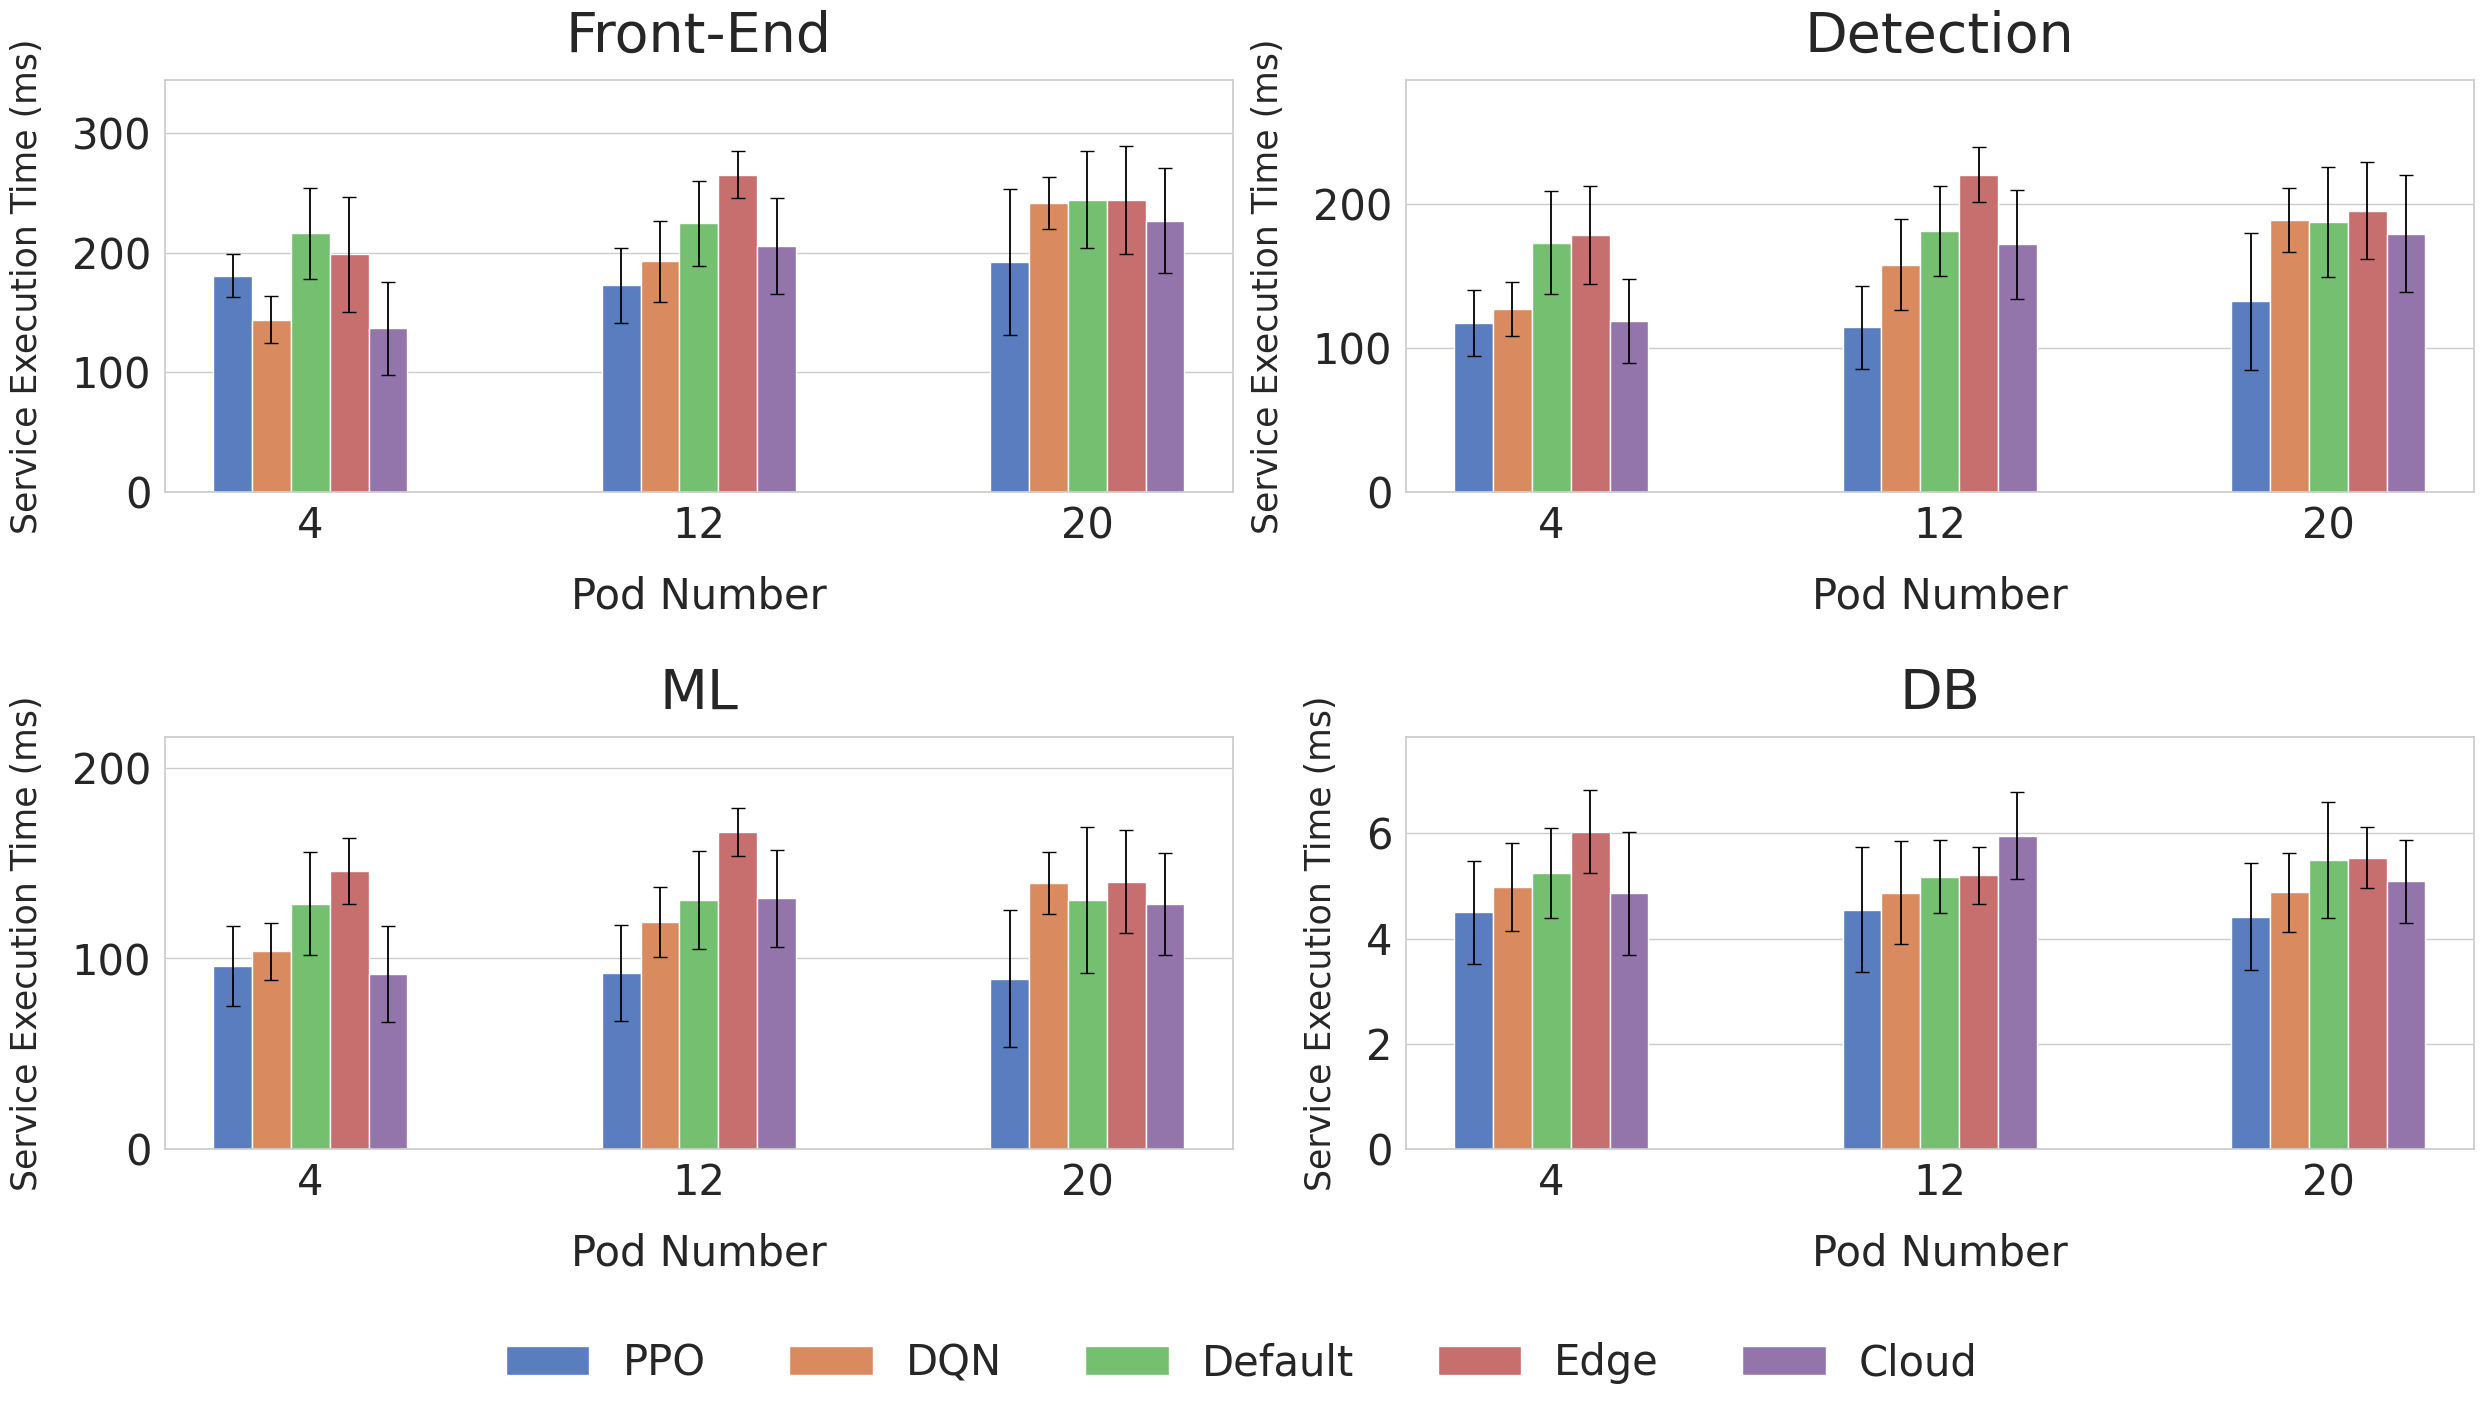

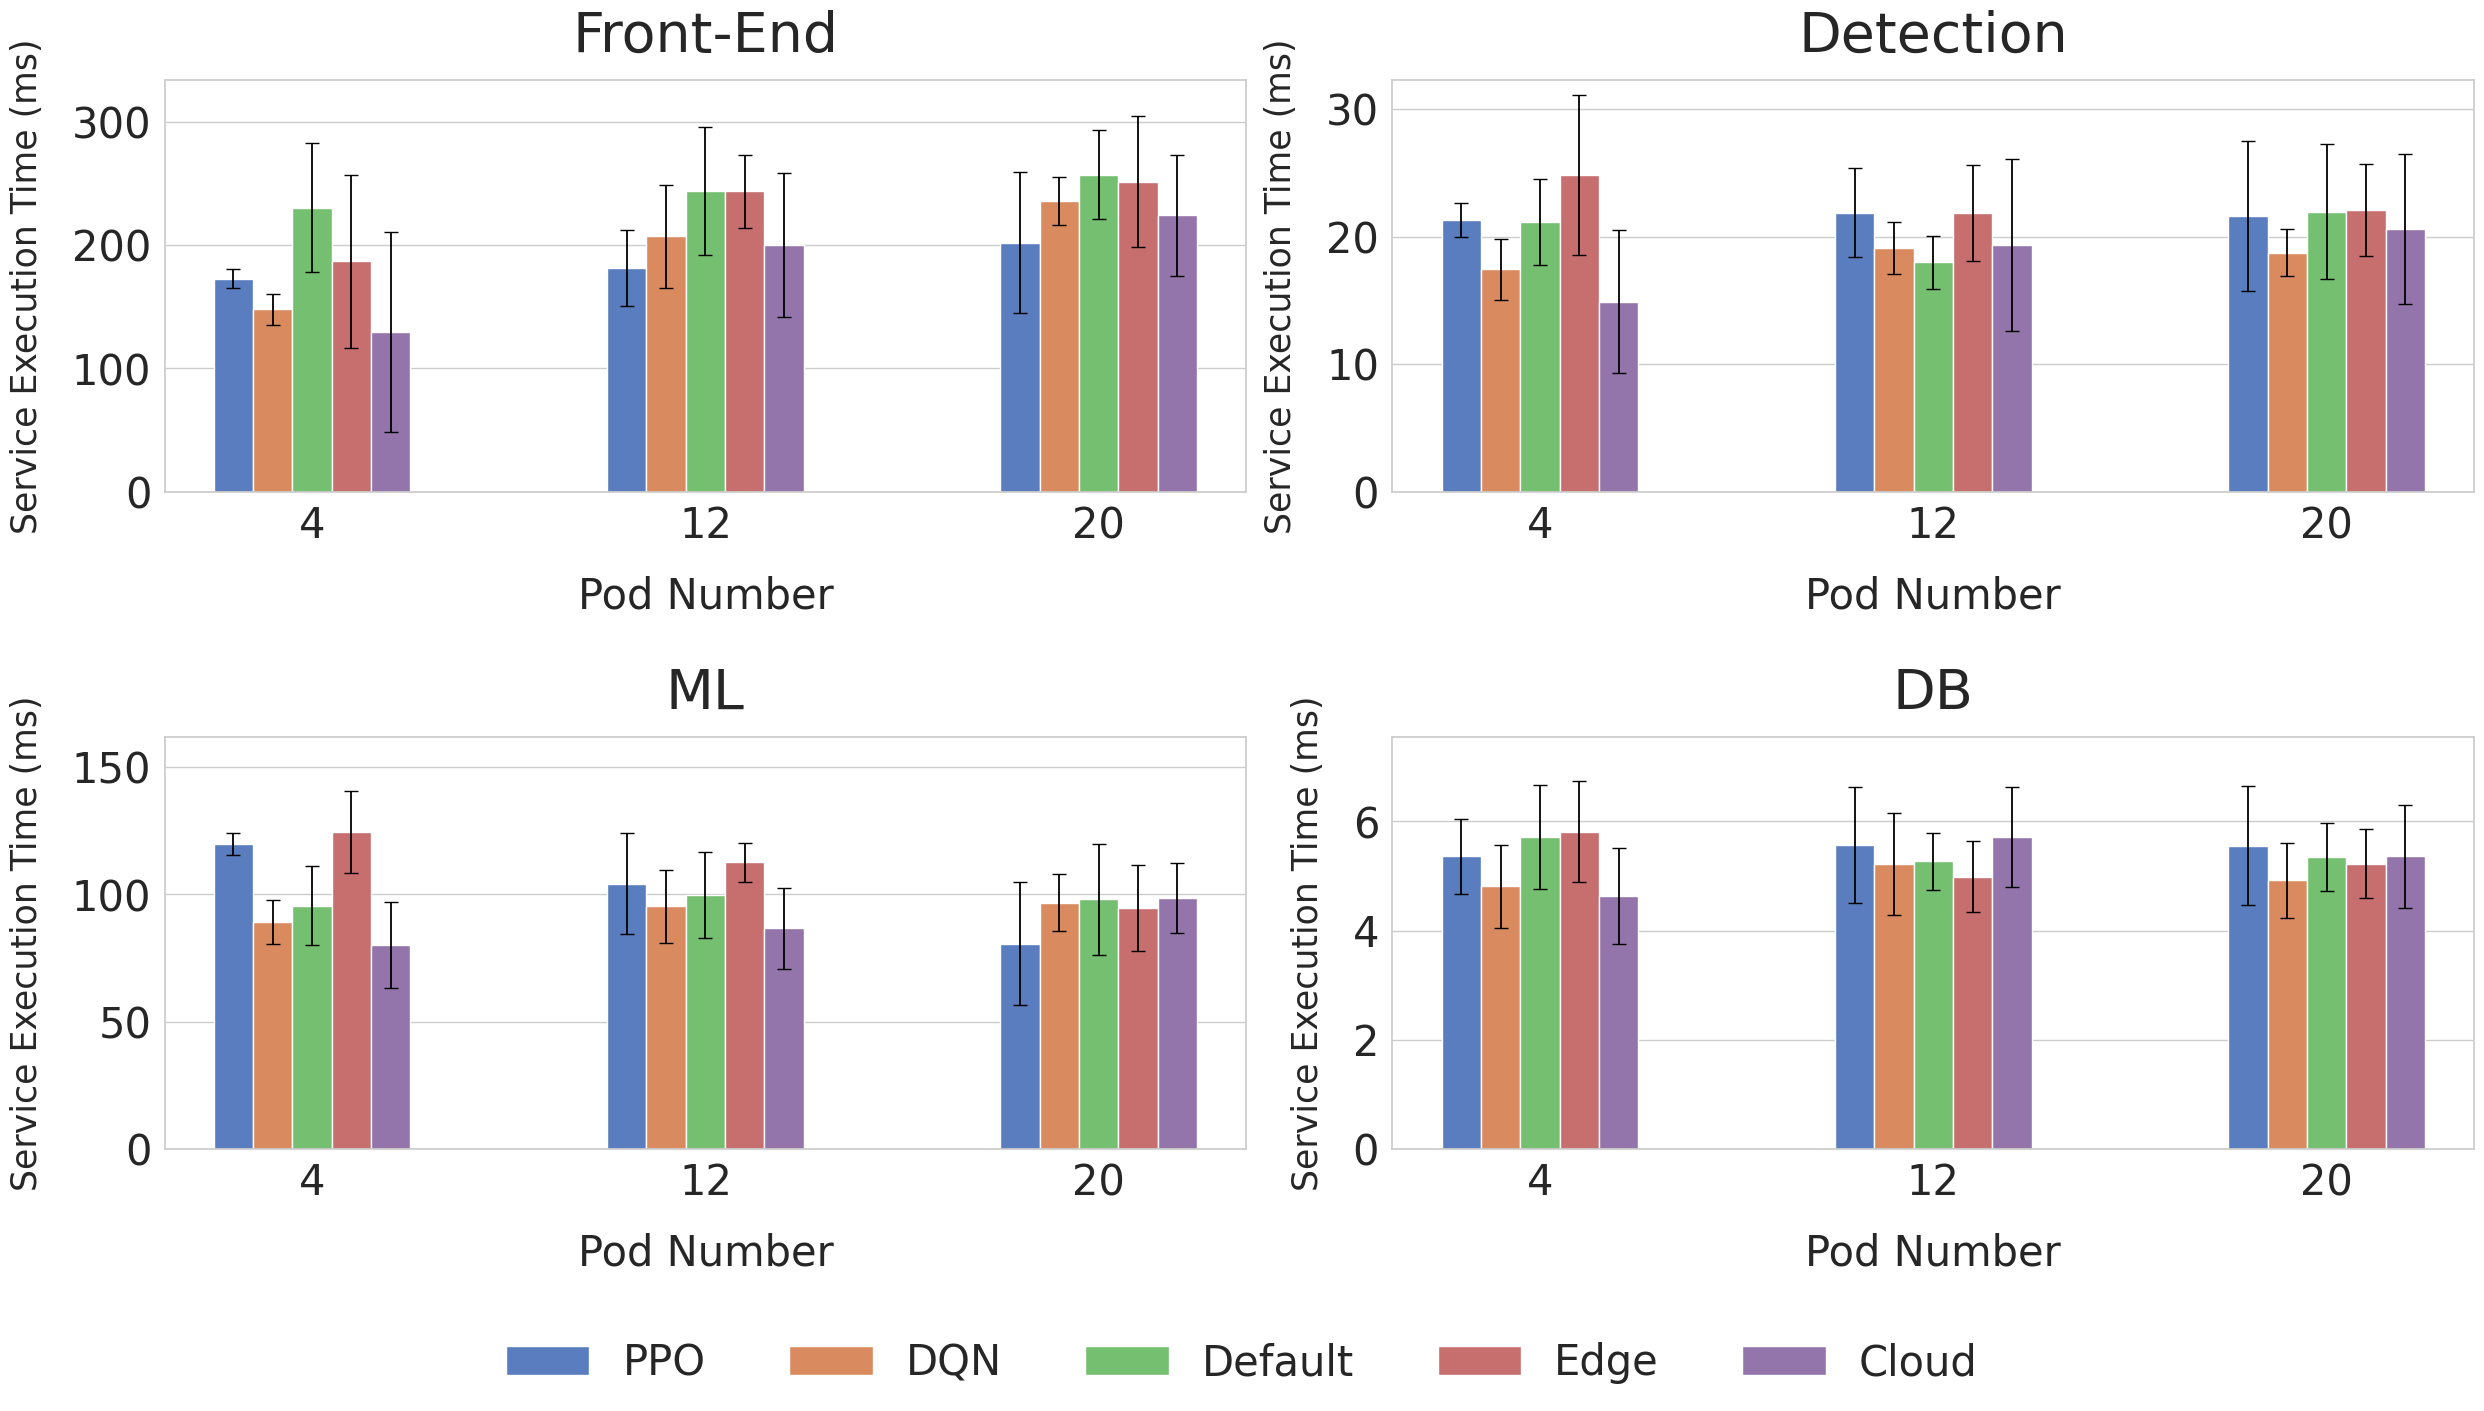

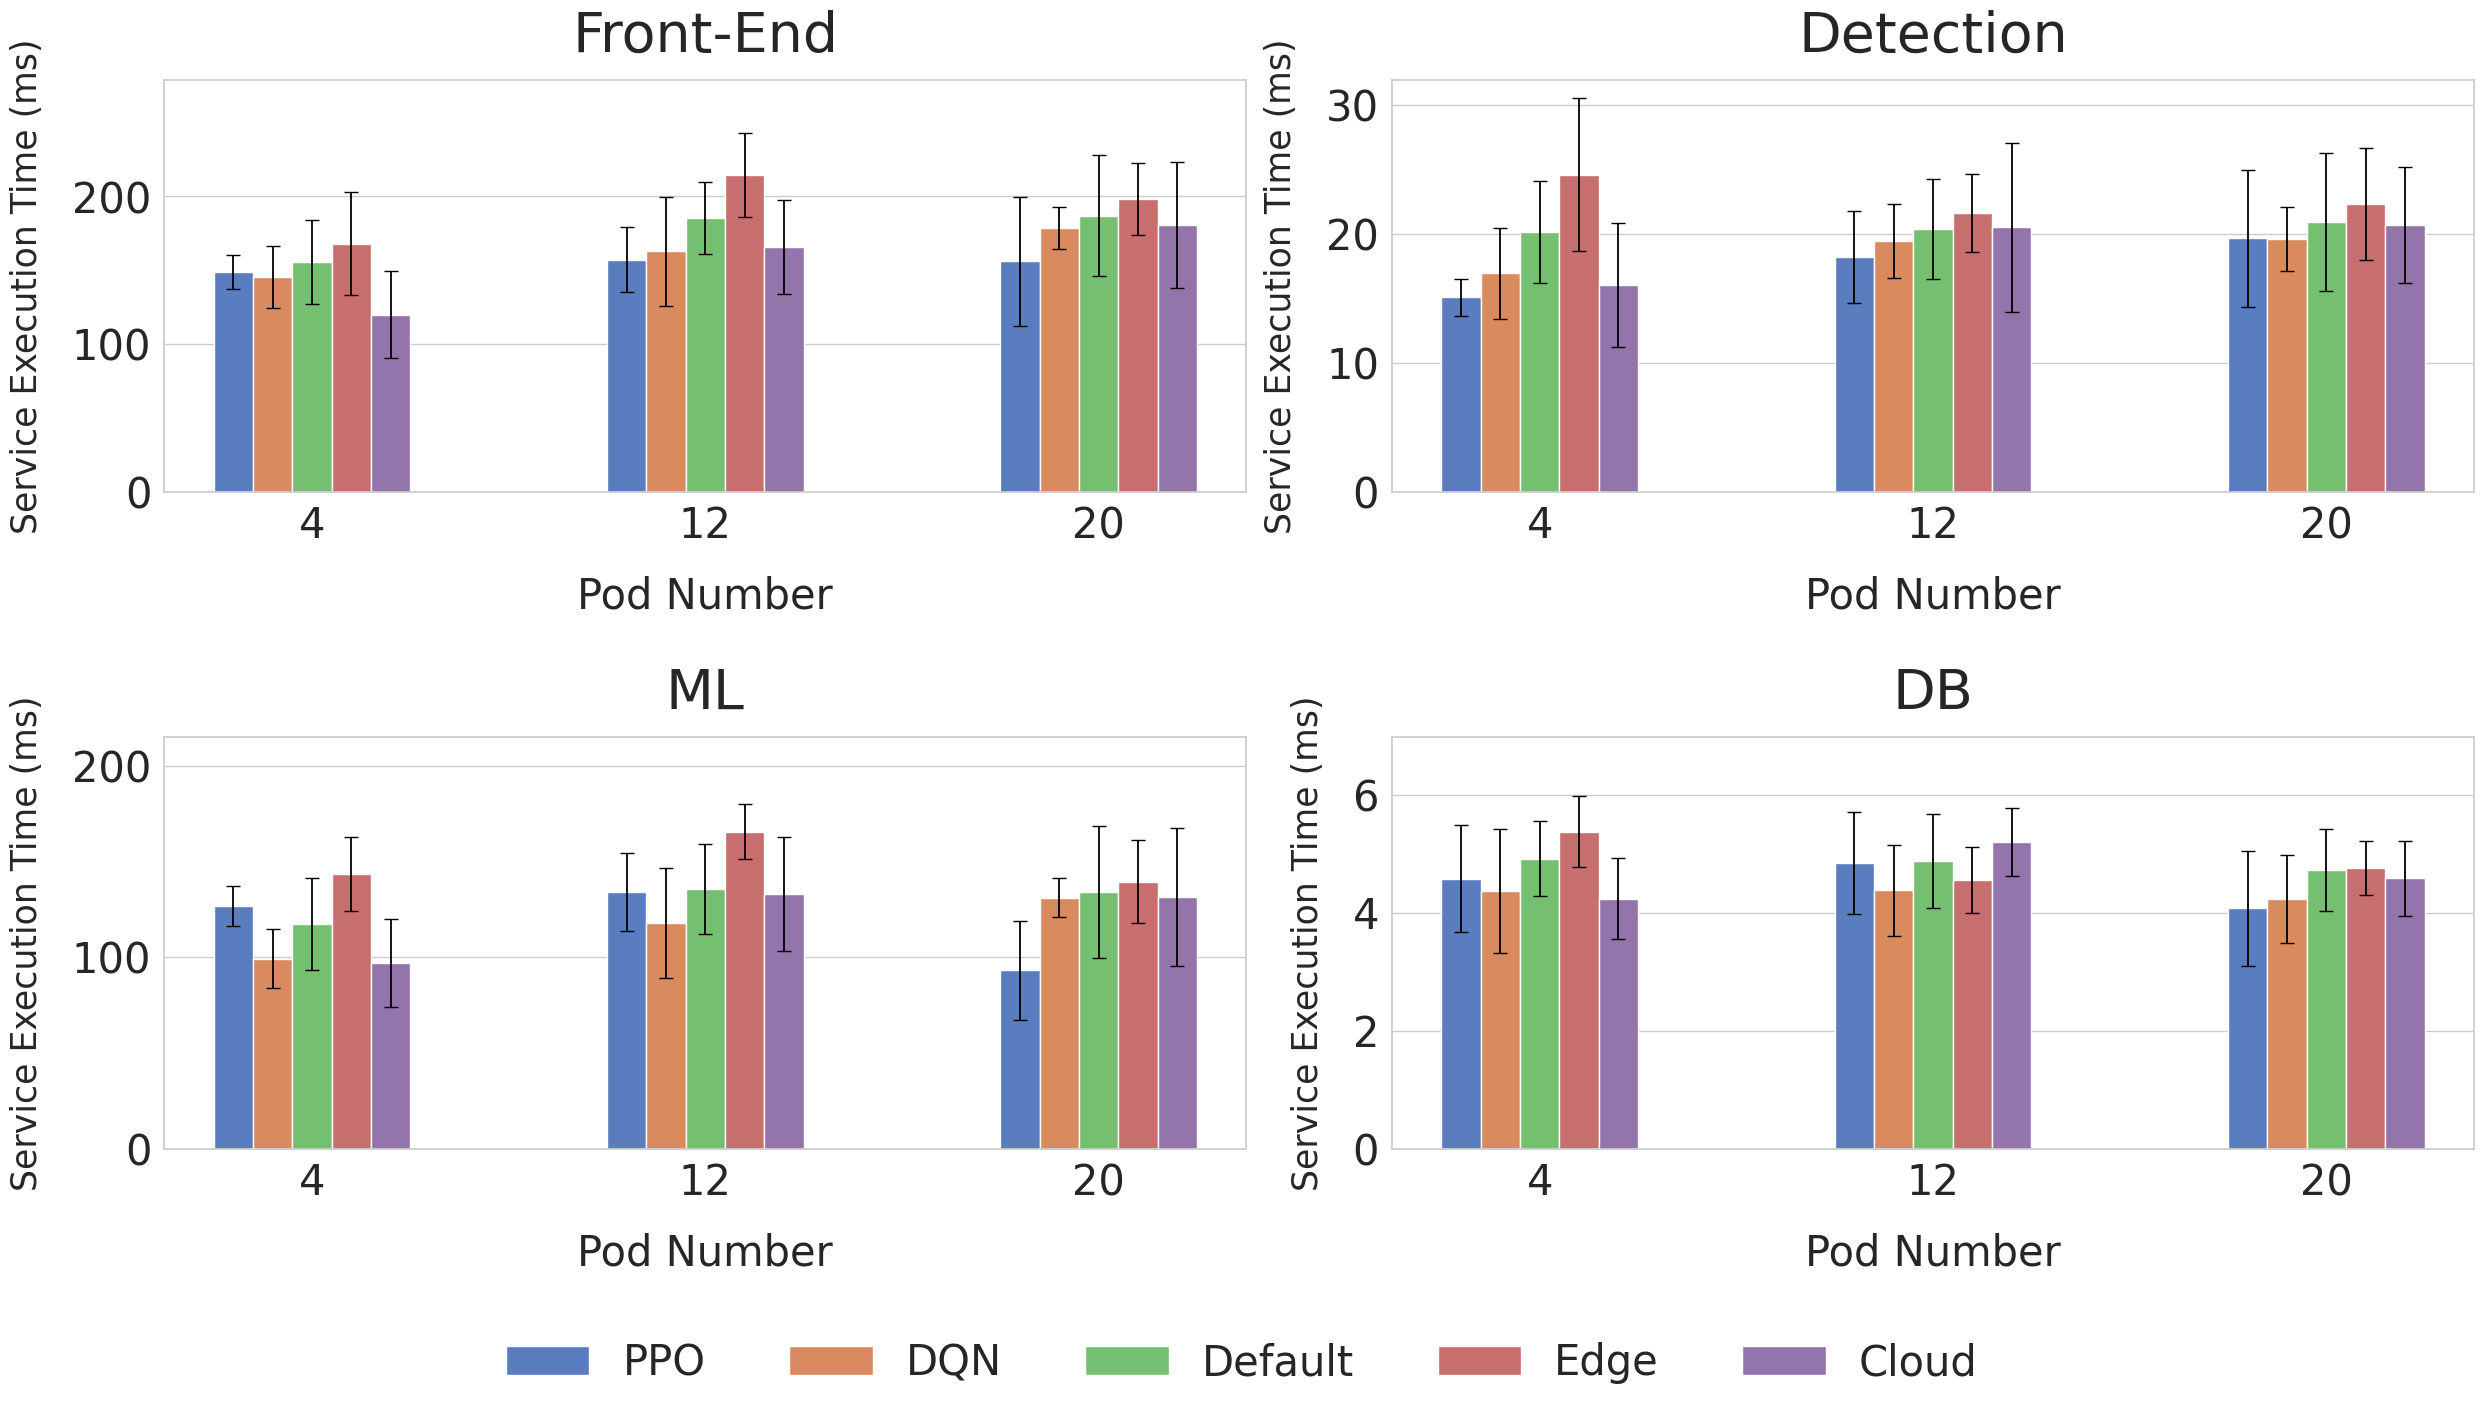

In [6]:
for pattern in ['chain', 'aggregator_sequential', 'aggregator_parallel']:
    compare_and_plot_latency(pattern, [1, 3, 5], f"{output_path}/latency_comparison_{pattern}.png")